In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import geopandas as gpd 

%load_ext autoreload
%autoreload 2

### 1. Data import

#### 1.2 Read US shapefiles

<Axes: >

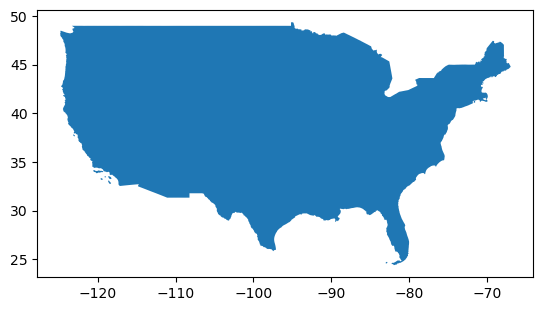

In [2]:
us_shape = gpd.read_file('../data/tl_2018_us_county/tl_2018_us_county.shp').to_crs("EPSG:4326")

# filter continental US
us_continental_counties = us_shape.cx[-66:-125, 24:50].reset_index(drop=True)
us_continental_boundary = us_continental_counties.dissolve()
us_continental_boundary.plot()

#### 1.2 Read MODIS start dates

In [11]:
modis_dates = pd.read_csv("../data/MODIS_dates.csv", sep=";")
modis_dates = modis_dates.apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))

modis_dates.iloc[6:9]

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
6,2003-02-18,2004-02-18,2005-02-18,2006-02-18,2007-02-18,2008-02-18,2009-02-18,2010-02-18,2011-02-18,2012-02-18,2013-02-18,2014-02-18,2015-02-18,2016-02-18,2017-02-18,2018-02-18,2019-02-18,2020-02-18,2021-02-18
7,2003-02-26,2004-02-26,2005-02-26,2006-02-26,2007-02-26,2008-02-26,2009-02-26,2010-02-26,2011-02-26,2012-02-26,2013-02-26,2014-02-26,2015-02-26,2016-02-26,2017-02-26,2018-02-26,2019-02-26,2020-02-26,2021-02-26
8,2003-03-06,2004-03-05,2005-03-06,2006-03-06,2007-03-06,2008-03-05,2009-03-06,2010-03-06,2011-03-06,2012-03-05,2013-03-06,2014-03-06,2015-03-06,2016-03-05,2017-03-06,2018-03-06,2019-03-06,2020-03-05,2021-03-06


#### 1.3 Read ECMWF seasonal forecasts

In [98]:
filtered_coords = pd.read_csv("../data/filtered_coords_ecmwf.csv")
# read hindcasts
list_hindcasts = []
#for filename in ["apr_2003_09", "apr_2010_16", "apr_2017_23"]:
for filename in ["apr_2003_09"]:
    print("reading {}".format(filename))
    df = xr.open_dataset("../data/ecmwf_grib/" + filename.lower() + ".grib")
    print("ensembles mean") # Note: This is subject to change for probabilistic forecasting
    df = df.mean("number")
    print("to dataframe")
    df = df.to_dataframe().dropna().reset_index()
    print("filter coordinates to continental US")
    df = df.merge(filtered_coords[["latitude", "longitude"]], on=["latitude", "longitude"], how="right")
    print("convert to datetime")
    df["valid_time"] = pd.to_datetime(df["valid_time"])
    df["time"] = pd.to_datetime(df["time"])
    list_hindcasts.append(df)

reading apr_2003_09
ensembles mean
to dataframe
filter coordinates to continental US
convert to datetime


### 2. Preprocess

#### 2.1 Align with date bins from MODIS

In [105]:
li = []
for year in df["time"].dt.year.unique():
    ecmwf_year = df[df["time"].dt.year == year].reset_index(drop=True)
    ecmwf_year["location"] = ecmwf_year["latitude"].astype(int).astype(str) + ", " + ecmwf_year["longitude"].astype(int).astype(str)

    start_date = pd.to_datetime(np.intersect1d(modis_dates.stack().values, ecmwf_year["valid_time"].drop_duplicates().sort_values()).min())
    end_date = min(pd.to_datetime(datetime(year, 12, 31)), pd.to_datetime(np.intersect1d(modis_dates.stack().values, ecmwf_year["valid_time"].drop_duplicates().sort_values()[:-7]).max()))
    days_to_end_of_forecast = (end_date - start_date).days + 1
    dates_to_end_of_forecast = pd.date_range(start_date, periods=days_to_end_of_forecast, freq='D')
    
    ecmwf_year_resampled = (
                            pd.DataFrame(dates_to_end_of_forecast, index=range(days_to_end_of_forecast), columns=["start_date_bin"])
                                .merge(ecmwf_year, left_on="start_date_bin", right_on="valid_time", how="left")
                                .groupby(["time", "location"]).resample("8D", on="start_date_bin")[["t2m", "mx2t24", "mn2t24", "tp"]].mean()
                                .reset_index()
                            )

    li.append(ecmwf_year_resampled)

ecmwf_resampled = pd.concat(li)

#### 2.1 Assign counties to grid cells

In [129]:
counties_with_ecmwf = pd.DataFrame(index=pd.MultiIndex.from_product([ecmwf_resampled["time"].unique().tolist(), 
                                              ecmwf_resampled["start_date_bin"].unique().tolist(),
                                              us_continental_counties.COUNTYNS.unique()], names=["init_date", "modis_bin", "countyID"])).reset_index()
counties_with_ecmwf = counties_with_ecmwf.merge(us_continental_counties[["COUNTYNS", "geometry"]], left_on="countyID", right_on="COUNTYNS", how="left")

counties_with_ecmwf = gpd.GeoDataFrame(counties_with_ecmwf[["init_date", "modis_bin", "countyID", "geometry"]], geometry="geometry")

counties_with_ecmwf.head()

,init_date,modis_bin,countyID,geometry
0,2003-04-01,2003-04-07,00835841,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,2003-04-01,2003-04-07,01513275,"POLYGON ((-123.43640 46.23819, -123.44759 46.2..."
2,2003-04-01,2003-04-07,00933054,"POLYGON ((-104.56739 33.99756, -104.56772 33.9..."
3,2003-04-01,2003-04-07,00835876,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,2003-04-01,2003-04-07,00835886,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [134]:
ecmwf_resampled[["latitude", "longitude"]] = ecmwf_resampled["location"].str.split(", ", expand=True).rename(columns={0: "latitude", 1: "longitude"})
ecmwf_geo = gpd.GeoDataFrame(ecmwf_resampled, geometry=gpd.points_from_xy(ecmwf_resampled["longitude"], ecmwf_resampled["latitude"]))
ecmwf_geo.head()

,time,location,start_date_bin,t2m,mx2t24,mn2t24,tp,latitude,longitude,geometry
0,2003-04-01,"25, -81",2003-04-07,297.449097,299.043701,295.882324,0.009665,25,-81,POINT (-81.00000 25.00000)
1,2003-04-01,"25, -81",2003-04-15,297.778534,299.265259,295.830658,0.030414,25,-81,POINT (-81.00000 25.00000)
2,2003-04-01,"25, -81",2003-04-23,298.457489,300.028992,296.462097,0.044013,25,-81,POINT (-81.00000 25.00000)
3,2003-04-01,"25, -81",2003-05-01,298.850311,300.438263,296.809265,0.058636,25,-81,POINT (-81.00000 25.00000)
4,2003-04-01,"25, -81",2003-05-09,299.288391,300.834320,297.300293,0.077952,25,-81,POINT (-81.00000 25.00000)
